# 2021-11-10 Finite elements

## Last time

* Stable numerics
* Galerkin optimality
* Boundary conditions
* Properties of Galerkin methods

## Today

* Element restriction
* Finite element assembly
* Nonlinear problems
* LibCEED

In [55]:
using Plots
using LinearAlgebra
using SparseArrays
using FastGaussQuadrature

default(linewidth=4)

function my_spy(A)
    cmax = norm(vec(A), Inf)
    s = max(1, ceil(120 / size(A, 1)))
    spy(A, marker=(:square, s), c=:diverging_rainbow_bgymr_45_85_c67_n256, clims=(-cmax, cmax))
end

function vander_legendre_deriv(x, k=nothing)
    if isnothing(k)
        k = length(x) # Square by default
    end
    m = length(x)
    Q = ones(m, k)
    dQ = zeros(m, k)
    Q[:, 2] = x
    dQ[:, 2] .= 1
    for n in 1:k-2
        Q[:, n+2] = ((2*n + 1) * x .* Q[:, n+1] - n * Q[:, n]) / (n + 1)
        dQ[:, n+2] = (2*n + 1) * Q[:,n+1] + dQ[:,n]
    end
    Q, dQ
end

function febasis(P, Q)
    x, _ = gausslobatto(P)
    q, w = gausslegendre(Q)
    Pk, _ = vander_legendre_deriv(x)
    Bp, Dp = vander_legendre_deriv(q, P)
    B = Bp / Pk
    D = Dp / Pk
    x, q, w, B, D
end

febasis (generic function with 1 method)

![](../img/libCEED-2-trim.svg)

# General form
$$ \int_\Omega v\cdot f_0(u, \nabla u) + \nabla v\cdot f_1(u, \nabla u) = 0, \quad \forall v$$
we discretize as
$$ \sum_e \mathcal E_e^T \Big( B^T W \left\lvert \frac{\partial x}{\partial X} \right\rvert f_0(\tilde u, \nabla \tilde u) + D^T \left(\frac{\partial X}{\partial x}\right)^{T} W \left\lvert \frac{\partial x}{\partial X} \right\rvert f_1(\tilde u, \nabla\tilde u) \Big) = 0 $$
where $\tilde u = B \mathcal E_e u$ and $\nabla \tilde u = \frac{\partial X}{\partial x} D \mathcal E_e u$ are the values and gradients evaluated at quadrature points.

## Isoparametric mapping

Given the reference coordinates $X \in \hat K \subset R^n$ and physical coordinates $x(X)$, an integral on the physical element can be written
$$ \int_{K = x(\hat K)} f(x) dx = \int_K \underbrace{\left\lvert \frac{\partial x}{\partial X} \right\rvert}_{\text{determinant}} f(x(X)) dX .$$

| Notation | Meaning |
|---------|:-------------:|
| $x$ | physical coordinates |
| $X$ | reference coordinates |
| $\mathcal E_e$ | restriction from global vector to element $e$ |
| $B$ | values of nodal basis functions at quadrature ponits on reference element |
| $D$ | gradients of nodal basis functions at quadrature points on reference element|
| $W$ | diagonal matrix of quadrature weights on reference element |
| $\frac{\partial x}{\partial X} = D \mathcal E_e x $ | gradient of physical coordinates with respect to reference coordinates |
| $\left\lvert \frac{\partial x}{\partial X}\right\rvert$ | determinant of coordinate transformation at each quadrature point |
| $\frac{\partial X}{\partial x} = \left(\frac{\partial x}{\partial X}\right)^{-1}$ | derivative of reference coordinates with respect to physical coordinates |

# Finite element mesh and restriction

In [56]:
function fe1_mesh(P, nelem)
    x = LinRange(-1, 1, nelem+1)
    rows = Int[]
    cols = Int[]
    for i in 1:nelem
        append!(rows, (i-1)*P+1:i*P)
        append!(cols, (i-1)*(P-1)+1:i*(P-1)+1)
    end
    x, sparse(cols, rows, ones(nelem*P))'
end
P, nelem = 4, 3
x, E = fe1_mesh(P, nelem)
sparse(E)

12×10 SparseMatrixCSC{Float64, Int64} with 12 stored entries:
 1.0   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅   1.0   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅   1.0   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅   1.0   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅   1.0   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅   1.0   ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅   1.0   ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   1.0   ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   1.0   ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   1.0   ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   1.0   ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   1.0

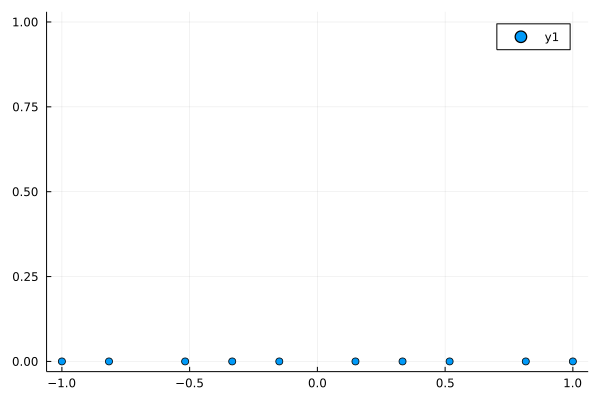

In [57]:
function xnodal(x, P)
    nelem = length(x) - 1
    xn = Float64[]
    xref, _ = gausslobatto(P)
    for i in 1:nelem
        xL, xR = x[i:i+1]
        append!(xn, (xL+xR)/2 .+ (xR-xL)/2 * xref[1+(i>1):end])
    end
    xn
end
xn = xnodal(x, 4)
scatter(xn, zero, marker=:auto)

# Finite element building blocks

In [58]:
struct FESpace
    P::Int
    Q::Int
    nelem::Int
    x::Vector
    xn::Vector
    Et::Adjoint{Float64, SparseMatrixCSC{Float64, Int64}}
    q::Vector
    w::Vector
    B::Matrix
    D::Matrix
    function FESpace(P, Q, nelem)
        x, Et = fe1_mesh(P, nelem)
        xn = xnodal(x, P)
        _, q, w, B, D = febasis(P, Q)
        new(P, Q, nelem, x, xn, Et, q, w, B, D)
    end
end

In [59]:
function fe_element(fe, e)
    xL, xR = fe.x[e:e+1]
    q = (xL+xR)/2 .+ (xR-xL)/2*fe.q
    w = (xR - xL)/2 * fe.w
    E = fe.Et'[:, (e-1)*fe.P+1:e*fe.P]'
    dXdx = ones(fe.Q) * 2 / (xR - xL)
    q, w, E, dXdx
end

fe_element (generic function with 1 method)

# Finite element residual assembly
$$ v^T F(u) \sim \int_\Omega v\cdot f_0(u, \nabla u) + \nabla v\cdot f_1(u, \nabla u) = 0, \quad \forall v$$
$$ \sum_e \mathcal E_e^T \Big( B^T W \left\lvert \frac{\partial x}{\partial X} \right\rvert f_0(\tilde u, \nabla \tilde u) + D^T \left(\frac{\partial X}{\partial x}\right)^{T} W \left\lvert \frac{\partial x}{\partial X} \right\rvert f_1(\tilde u, \nabla\tilde u) \Big) = 0 $$
where $\tilde u = B \mathcal E_e u$ and $\nabla \tilde u = \frac{\partial X}{\partial x} D \mathcal E_e u$ are the values and gradients evaluated at quadrature points.

In [60]:
kappa(x) = 0.6 .+ 0.4*sin(pi*x/2)
fq(q, u, Du) = 0*u .- 1, kappa.(q) .* Du
dfq(q, u, du, Du, Ddu) = 0*du, kappa.(q) .* Ddu

function fe_residual(u_in, fe, fq; bci=[1], bcv=[1.])
    u = copy(u_in); v = zero(u)
    u[bci] = bcv
    for e in 1:fe.nelem
        q, w, E, dXdx = fe_element(fe, e)
        B, D = fe.B, fe.D
        ue = E * u
        uq = B * ue
        Duq = dXdx .* (D * ue)
        f0, f1 = fq(q, uq, Duq)
        ve = B' * (w .* f0) + D' * (dXdx .* w .* f1)
        v += E' * ve
    end
    v[bci] = u_in[bci] - u[bci]
    v
end

fe_residual (generic function with 1 method)

In [61]:
import NLsolve: nlsolve

fe = FESpace(3, 3, 5)
u0 = zero(fe.xn)
sol = nlsolve(u -> fe_residual(u, fe, fq), u0; method=:newton)
#plot(fe.xn, sol.zero, marker=:auto)

Results of Nonlinear Solver Algorithm
 * Algorithm: Newton with line-search
 * Starting Point: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 * Zero: [1.0000000000039475, 2.841018305024411, 4.238906485222131, 5.188016952771728, 5.816050622253204, 6.227791209380689, 6.501764010258901, 6.681877766277991, 6.795822293427263, 6.858907410246209, 6.879070690434546]
 * Inf-norm of residuals: 0.000000
 * Iterations: 1
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 2
 * Jacobian Calls (df/dx): 2

# Finite element Jacobian assembly

$$ v^T F(u) \sim \int_\Omega v\cdot f_0(u, \nabla u) + \nabla v\cdot f_1(u, \nabla u) = 0, \quad \forall v$$
$$ v^T J(u) du \sim \int_\Omega v\cdot df_0(u, du, \nabla u, \nabla du) + \nabla v\cdot df_1(u, du, \nabla u, \nabla du) = 0, \quad \forall v$$

In [62]:
function fe_jacobian(u_in, fe, dfq; bci=[1], bcv=[1.])
    u = copy(u_in); u[bci] = bcv
    rows, cols, vals = Int[], Int[], Float64[]
    for e in 1:fe.nelem
        q, w, E, dXdx = fe_element(fe, e)
        B, D, P = fe.B, fe.D, fe.P
        ue = E * u
        uq = B * ue; Duq = dXdx .* (D * ue)
        K = zeros(P, P)
        for j in 1:fe.P
            du = B[:,j]
            Ddu = dXdx .* D[:,j]
            df0, df1 = dfq(q, uq, du, Duq, Ddu)
            K[:,j] = B' * (w .* df0) + D' * (dXdx .* w .* df1)
        end
        inds = rowvals(E')
        append!(rows, kron(ones(P), inds))
        append!(cols, kron(inds, ones(P)))
        append!(vals, vec(K))
    end
    A = sparse(rows, cols, vals)
    A[bci, :] .= 0; A[:, bci] .= 0
    A[bci,bci] = diagm(ones(length(bci)))
    A
end

fe_jacobian (generic function with 1 method)

In [63]:
sol = nlsolve(u -> fe_residual(u, fe, fq),
    u -> fe_jacobian(u, fe, dfq),
    u0;
    method=:newton)

Results of Nonlinear Solver Algorithm
 * Algorithm: Newton with line-search
 * Starting Point: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 * Zero: [1.0, 2.8410183049139395, 4.238906485042849, 5.1880169525357305, 5.8160506219732895, 6.227791209068442, 6.501764009933425, 6.681877765936257, 6.795822293071308, 6.8589074098787215, 6.879070690065479]
 * Inf-norm of residuals: 0.000000
 * Iterations: 1
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 2
 * Jacobian Calls (df/dx): 2

# Spy on the Jacobian

In [64]:
@show cond(Matrix(J))

fe = FESpace(6, 6, 4)
u0 = zero(fe.xn)
J = fe_jacobian(u0, fe, dfq)
my_spy(J)

LoadError: UndefVarError: J not defined

* What is interesting about this matrix structure?
  * What would the matrix structure look like for a finite difference method that is 6th order accurate?

# A nonlinear problem

$$ \int_\Omega \nabla v (1 + u^2) \nabla u - v = 0 $$

In [65]:
function fq(q, u, Du)
    f0 = 0*u .- 1
    f1 = (1 .+ u.^2) .* Du
    f0, f1
end
function dfq(q, u, du, Du, Ddu)
    df0 = 0*du
    df1 = (1 .+ u.^2) .* Ddu + 2u .* du .* Du
    df0, df1
end
sol = nlsolve(u -> fe_residual(u, fe, fq),
    u -> fe_jacobian(u, fe, dfq),
    u0; method=:newton)

Results of Nonlinear Solver Algorithm
 * Algorithm: Newton with line-search
 * Starting Point: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 * Zero: [1.0, 1.1739863026457675, 1.307777401051926, 1.4129878095812518, 1.4964042939005306, 1.5622906363804245, 1.6134021931347737, 1.6516021901518985, 1.6781120101275795, 1.6937298372175207, 1.698885489993836]
 * Inf-norm of residuals: 0.000000
 * Iterations: 6
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 7
 * Jacobian Calls (df/dx): 7

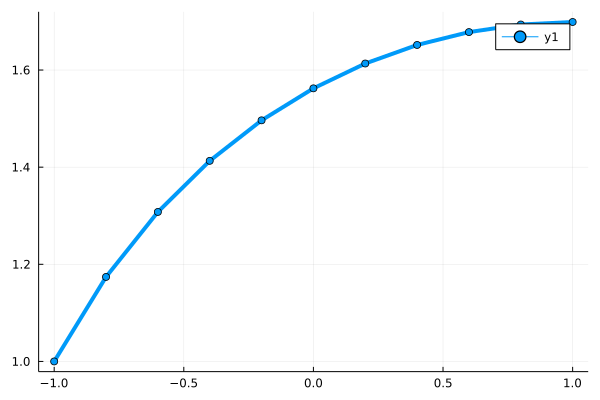

In [66]:
plot(fe.xn, sol.zero, marker=:auto)

# Advection-diffusion (time independent)

\begin{align}
\nabla\cdot\big[ \mathbf w u - \kappa \nabla u \big] &= 1 & \int_\Omega \nabla v \cdot \Big[-\mathbf w u + \kappa \nabla u \big] &= \int_\Omega v 1, \forall v
\end{align}

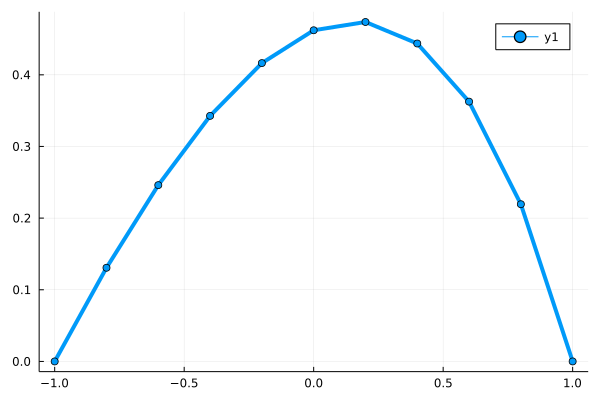

In [67]:
wind = 1
fq(q, u, Du) = -one.(u), -wind .* u + 1 * Du
N = length(fe.xn)
sol = nlsolve(u -> fe_residual(u, fe, fq; bci=[1, N], bcv=[0, 0]), zero(fe.xn), method=:newton)
plot(fe.xn, sol.zero, marker=:auto)

# LibCEED

In [68]:
using LibCEED

ceed = Ceed()

Ceed
  Ceed Resource: /cpu/self/opt/blocked
  Preferred MemType: host

In [69]:
function fe1_ceed(ceed, P, nelem)
    offsets = CeedInt[]
    # libceed uses 0-based indexing
    for e in 0:nelem-1
        append!(offsets, e*(P-1):(e+1)*(P-1))
    end
    E = create_elem_restriction(ceed, nelem, P, 1, 1, nelem*(P-1)+1, offsets)
end

P, Q, nelem = 5, 5, 4
E = fe1_ceed(ceed, P, nelem)

CeedElemRestriction from (17, 1) to 4 elements with 5 nodes each and component stride 1

In [70]:
basis = create_tensor_h1_lagrange_basis(ceed, 1, 1, P, Q, GAUSS)

CeedBasis: dim=1 P=5 Q=5
      qref1d:	 -0.90617985	 -0.53846931	  0.00000000	  0.53846931	  0.90617985
   qweight1d:	  0.23692689	  0.47862867	  0.56888889	  0.47862867	  0.23692689
    interp1d[0]:	  0.59337070	  0.51643520	 -0.16382364	  0.08322282	 -0.02920508
    interp1d[1]:	 -0.10048257	  0.93136610	  0.22966726	 -0.09069490	  0.03014411
    interp1d[2]:	  0.00000000	  0.00000000	  1.00000000	  0.00000000	  0.00000000
    interp1d[3]:	  0.03014411	 -0.09069490	  0.22966726	  0.93136610	 -0.10048257
    interp1d[4]:	 -0.02920508	  0.08322282	 -0.16382364	  0.51643520	  0.59337070
      grad1d[0]:	 -3.70533645	  4.33282117	 -0.90392454	  0.42067623	 -0.14423641
      grad1d[1]:	 -0.52871527	 -1.09765797	  2.13259378	 -0.74973857	  0.24351802
      grad1d[2]:	  0.37500000	 -1.33658458	  0.00000000	  1.33658458	 -0.37500000
      grad1d[3]:	 -0.24351802	  0.74973857	 -2.13259378	  1.09765797	  0.52871527
      grad1d[4]:	  0.14423641	 -0.42067623	  0.90392454	 -4.33282117	  3.705336

# libCEED `QFunction` and `Operator`

\begin{gather*}
    v^T F(u) \sim \int_\Omega v \cdot \color{olive}{f_0(u, \nabla u)} + \nabla v \!:\! \color{olive}{f_1(u, \nabla u)} \quad
    v^T J w \sim \int_\Omega \begin{bmatrix} v \\ \nabla v \end{bmatrix}^T \color{teal}{\begin{bmatrix} f_{0,0} & f_{0,1} \\ f_{1,0} & f_{1,1} \end{bmatrix}}
    \begin{bmatrix} w \\ \nabla w \end{bmatrix} \\
    u = B_I \mathcal E_e u_L \qquad \nabla u = \frac{\partial X}{\partial x} B_{\nabla} \mathcal E_e u_L \\
    J w = \sum_e \mathcal E_e^T \begin{bmatrix} B_I \\ B_{\nabla} \end{bmatrix}^T
    \underbrace{\begin{bmatrix} I & \\ & \left( \frac{\partial X}{\partial x}\right)^T \end{bmatrix} W_q \color{teal}{\begin{bmatrix} f_{0,0} & f_{0,1} \\ f_{1,0} & f_{1,1} \end{bmatrix}} \begin{bmatrix} I & \\ & \left( \frac{\partial X}{\partial x}\right) \end{bmatrix}}_{\text{coefficients at quadrature points}} \begin{bmatrix} B_I \\ B_{\nabla} \end{bmatrix} \mathcal E_e w_L
\end{gather*}

In [108]:
@interior_qf setup_geom = (
    ceed, dim=1,
    (dxdX, :in, EVAL_GRAD, 1),
    (w, :in, EVAL_WEIGHT),
    (qdata, :out, EVAL_NONE, 1, 2),
    begin
        qdata[1] = w * abs(dxdX[1])
        qdata[2] = w / abs(dxdX[1])
    end
)

0

In [111]:
@interior_qf apply_diff = (
    ceed, dim=1,
    (qdata, :in, EVAL_NONE, 2),
    (dudX, :in, EVAL_GRAD, 1),
    (v, :out, EVAL_INTERP, 1),
    (dvdX, :out, EVAL_GRAD, 1),
    begin
        v .= qdata[1] * -1
        dvdX .= qdata[2] * dudX
    end
)

0

# Wire up restrictions and operators

In [112]:
qdata = CeedVector(ceed, nelem*Q*2)
x = CeedVector(ceed, nelem+1)
x[] = LinRange(-1, 1, nelem+1)
Ex = fe1_ceed(ceed, 2, nelem)
Eq = create_elem_restriction_strided(ceed, nelem, Q, 2, nelem*Q*2, STRIDES_BACKEND)
Bx = create_tensor_h1_lagrange_basis(ceed, 1, 1, 2, Q, GAUSS)

op_setup = Operator(ceed, qf=setup_geom, fields=[
        (:dxdX, Ex, Bx, CeedVectorActive()),
        (:w, ElemRestrictionNone(), Bx, CeedVectorNone()),
        (:qdata, Eq, BasisCollocated(), CeedVectorActive()),
        ])

CeedOperator
  3 Fields
  2 Input Fields:
    Input Field [0]:
      Name: "dxdX"
      Active vector
    Input Field [1]:
      Name: "w"
      No vector
  1 Output Field:
    Output Field [0]:
      Name: "qdata"
      Collocated basis
      Active vector

In [113]:
apply!(op_setup, x, qdata)

op_diff = Operator(ceed, qf=apply_diff, fields=[
        (:qdata, Eq, BasisCollocated(), qdata),
        (:dudX, E, basis, CeedVectorActive()),
        (:v, E, basis, CeedVectorActive()),
        (:dvdX, E, basis, CeedVectorActive()),
        ])

CeedOperator
  4 Fields
  2 Input Fields:
    Input Field [0]:
      Name: "qdata"
      Collocated basis
    Input Field [1]:
      Name: "dudX"
      Active vector
  2 Output Fields:
    Output Field [0]:
      Name: "v"
      Active vector
    Output Field [1]:
      Name: "dvdX"
      Active vector

# Solve

In [115]:
function ceed_residual(u_in, op_diff; bci=[1], bcv=[1.])
    u = copy(u_in); v = zero(u)
    u[bci] = bcv
    uceed = CeedVector(ceed, length(u))
    setarray!(uceed, MEM_HOST, USE_POINTER, u)
    vceed = CeedVector(ceed, length(u))
    apply!(op_diff, uceed, vceed)
    v = witharray(Vector, vceed)
    v[bci] = u_in[bci] - u[bci]
    v
end

N = getlvectorsize(E)
sol = nlsolve(u -> ceed_residual(u, op_diff; bci=[1, N], bcv=[0, 0]), ones(N), method=:newton)

Results of Nonlinear Solver Algorithm
 * Algorithm: Newton with line-search
 * Starting Point: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
 * Zero: [-3.9475089863572066e-12, 0.08260957960239312, 0.21874999997080646, 0.32810470604827624, 0.3749999999584841, 0.4144412884027462, 0.4687499999651483, 0.4962729972393789, 0.5000000000237609, 0.4962729973023331, 0.4687500000248659, 0.41444128846070394, 0.3750000000810918, 0.3281047062415061, 0.21875000011356172, 0.08260957964624749, -3.9475089863572066e-12]
 * Inf-norm of residuals: 0.000000
 * Iterations: 1
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 2
 * Jacobian Calls (df/dx): 2

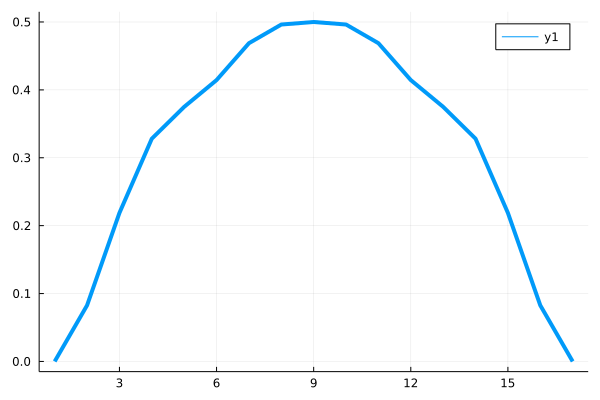

In [116]:
plot(sol.zero)